##  <center> John Salako </center>
### <center>Predictive Model for determining Experimental Site Response to N Fertilizer Addition</center>
#### <center>February 16, 2023</center>

In [1]:
# importing relevant modules
import numpy as np
import pandas as pd

# preprocessing libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split  # imports the train_test_split function
from sklearn.preprocessing import StandardScaler  # importing StandardScaler which performs feature engineering

# ML Classifier Algorithms
from sklearn.tree import DecisionTreeClassifier
# using various estimators
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# loading the metrics library
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import hiplot as hip

import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [2]:
# importing the target file
target = pd.read_csv('targets.csv')
target.head(6) 

site_id  year                 treatment  yield_bu_acre  plantN_lb_acre
0        6  2017      Reduced N fertilizer          153.5           164.8
1        6  2017  Grower Standard Practice          157.2           178.1
2       24  2017      Reduced N fertilizer          153.9           162.3
3       24  2017  Grower Standard Practice          158.1           177.7
4       26  2018      Reduced N fertilizer          181.1           156.7
5       26  2018  Grower Standard Practice          167.8           152.2

Check data to see if there are missing values ...

In [3]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_id         800 non-null    int64  
 1   year            800 non-null    int64  
 2   treatment       800 non-null    object 
 3   yield_bu_acre   800 non-null    float64
 4   plantN_lb_acre  800 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 31.4+ KB


## Questions

#### 1:
Re-format the `target.csv` dataset so that it contains the response of both traits at each 
site, rather than their raw values. Consider exploring the responses using visualization 
and descriptive statistics.

In [4]:
# Reformating the response variables
response = target[['yield_bu_acre', 'plantN_lb_acre', 'site_id']].groupby('site_id').diff().dropna()  # Obtaining the responses
site_year = pd.DataFrame(target[['site_id', 'year']], index=response.index)  # Extracting the corresponding site_id and year
response_df = pd.concat([site_year, response], axis=1, join='inner')  # Reformated dataframe
response_df.head()

site_id  year  yield_bu_acre  plantN_lb_acre
1        6  2017            3.7            13.3
3       24  2017            4.2            15.4
5       26  2018          -13.3            -4.5
7       42  2017            3.5            12.5
9       60  2017            6.0            20.4

In [5]:
# Validating the resulting dataframe
response_df.shape

(400, 4)

#### Descriptive Statistics and Visualization

In [6]:
response_df.describe()[['yield_bu_acre', 'plantN_lb_acre']].T

count      mean       std   min    25%   50%     75%   max
yield_bu_acre   400.0  3.206775  5.679090 -21.6  0.800  2.55   4.925  24.1
plantN_lb_acre  400.0  9.377000  7.282827  -9.9  3.975  8.90  14.300  27.1

I didn't include the `site_id` and `year` in the descriptive statistics because they are categorical values

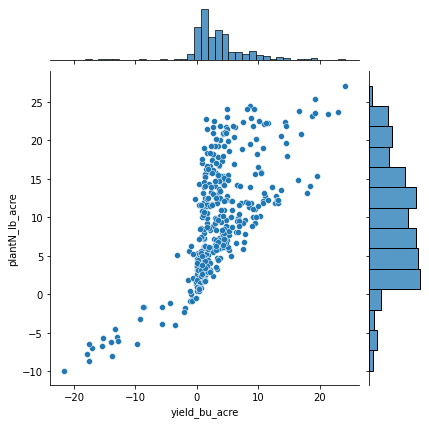

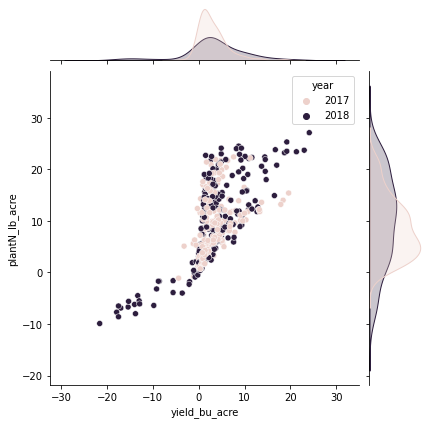

In [7]:
sns.jointplot(x= 'yield_bu_acre', y='plantN_lb_acre', data = response_df)
sns.jointplot(x= 'yield_bu_acre', y='plantN_lb_acre', hue='year', data = response_df)
plt.show()

👉👉 The data collected in the different years are fairly normally distributed when considered individually, but have some level of skewness when they are viewed together.

### 2:
Load the `predictors.csv` dataset and encode each feature according to their data type.
Consider scaling, imputation, dimensionality reduction or other pre-processing you 
deem necessary before modeling. Be prepared to justify your choices.

In [8]:
# importing the predictors file
predictors = pd.read_csv('predictors.csv')
predictors.head(10) 

site_id  year  N_fert_grower  N_fert_reduced  dul_dep  ll15_dep  \
0        6  2017            200             160    601.0     327.0   
1       24  2017            190             150      NaN     335.1   
2       26  2018            220             180    619.0     346.8   
3       42  2017            200             160    609.5     335.5   
4       60  2017            200             160    599.7     326.1   
5       74  2018            140             100    240.4     137.5   
6      105  2018            220             180    618.0     335.6   
7      114  2017            200             160    608.2     324.7   
8      116  2017            200             160    619.4     341.6   
9      120  2018            210             170    630.0       NaN   

   root_depth    whc  LAI_max  rain_annual  ...  junk6  junk7  junk8  junk9  \
0      1565.0  274.0    3.164       1064.0  ...   9.68   9.46   8.03     F5   
1      1573.0  272.7      NaN       1008.0  ...    NaN   1.89   8.03     F5   
2      1528.0  272.2    3.106       1469.0  ...   1.94   1.89  20.10    NaN   
3      1558.0  274.0      NaN        964.0  ...   5.81  24.60   4.01     F5   
4      1584.0  273.7    3.174       1145.0  ...   5.81  22.70   4.01     F5   
5      1581.0  102.9    2.618          NaN  ...   9.68   1.89  16.10     F5   
6      1592.0  282.4    3.496       1192.0  ...   1.94  18.90  20.10     F2   
7      1598.0  283.6      NaN       1049.0  ...   1.94   1.89    NaN     F5   
8      1607.0  277.8    3.506       1049.0  ...   9.68  18.90  16.10     F5   
9      1583.0  266.3    3.510       1220.0  ...   5.81   7.56  24.10     F5   

   junk10  junk11  junk12  junk13  junk14  junk15  
0      F2     NaN     0.0    65.0   122.0      F1  
1      F1     0.0     0.0    40.0   122.0      F1  
2      F1     0.0     0.0    40.0   122.0      F1  
3     NaN     0.0     0.0     NaN   122.0      F1  
4      F2     0.0     0.0     NaN   122.0      F2  
5      F2     0.0     0.0    40.0    42.7      F1  
6      F1     0.0     0.0    36.0   122.0      F1  
7      F2  9562.0     0.0     NaN   122.0     NaN  
8      F1  2597.0     NaN    31.0   122.0      F1  
9      F1     NaN     0.0    32.0   122.0      F1  

[10 rows x 71 columns]

#### Analyzing the Missingness

In [9]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   site_id          400 non-null    int64  
 1   year             400 non-null    int64  
 2   N_fert_grower    400 non-null    int64  
 3   N_fert_reduced   400 non-null    int64  
 4   dul_dep          367 non-null    float64
 5   ll15_dep         356 non-null    float64
 6   root_depth       368 non-null    float64
 7   whc              358 non-null    float64
 8   LAI_max          352 non-null    float64
 9   rain_annual      364 non-null    float64
 10  day_sow          362 non-null    float64
 11  swdef_photo_fw   363 non-null    float64
 12  swdef_expan_fw   361 non-null    float64
 13  swdef_pheno_fw   365 non-null    float64
 14  L1               367 non-null    float64
 15  day_v5           357 non-null    float64
 16  sw_dep_v5        355 non-null    float64
 17  biomass_v5      

Plotting the data to further analyze the missingness

<AxesSubplot:>

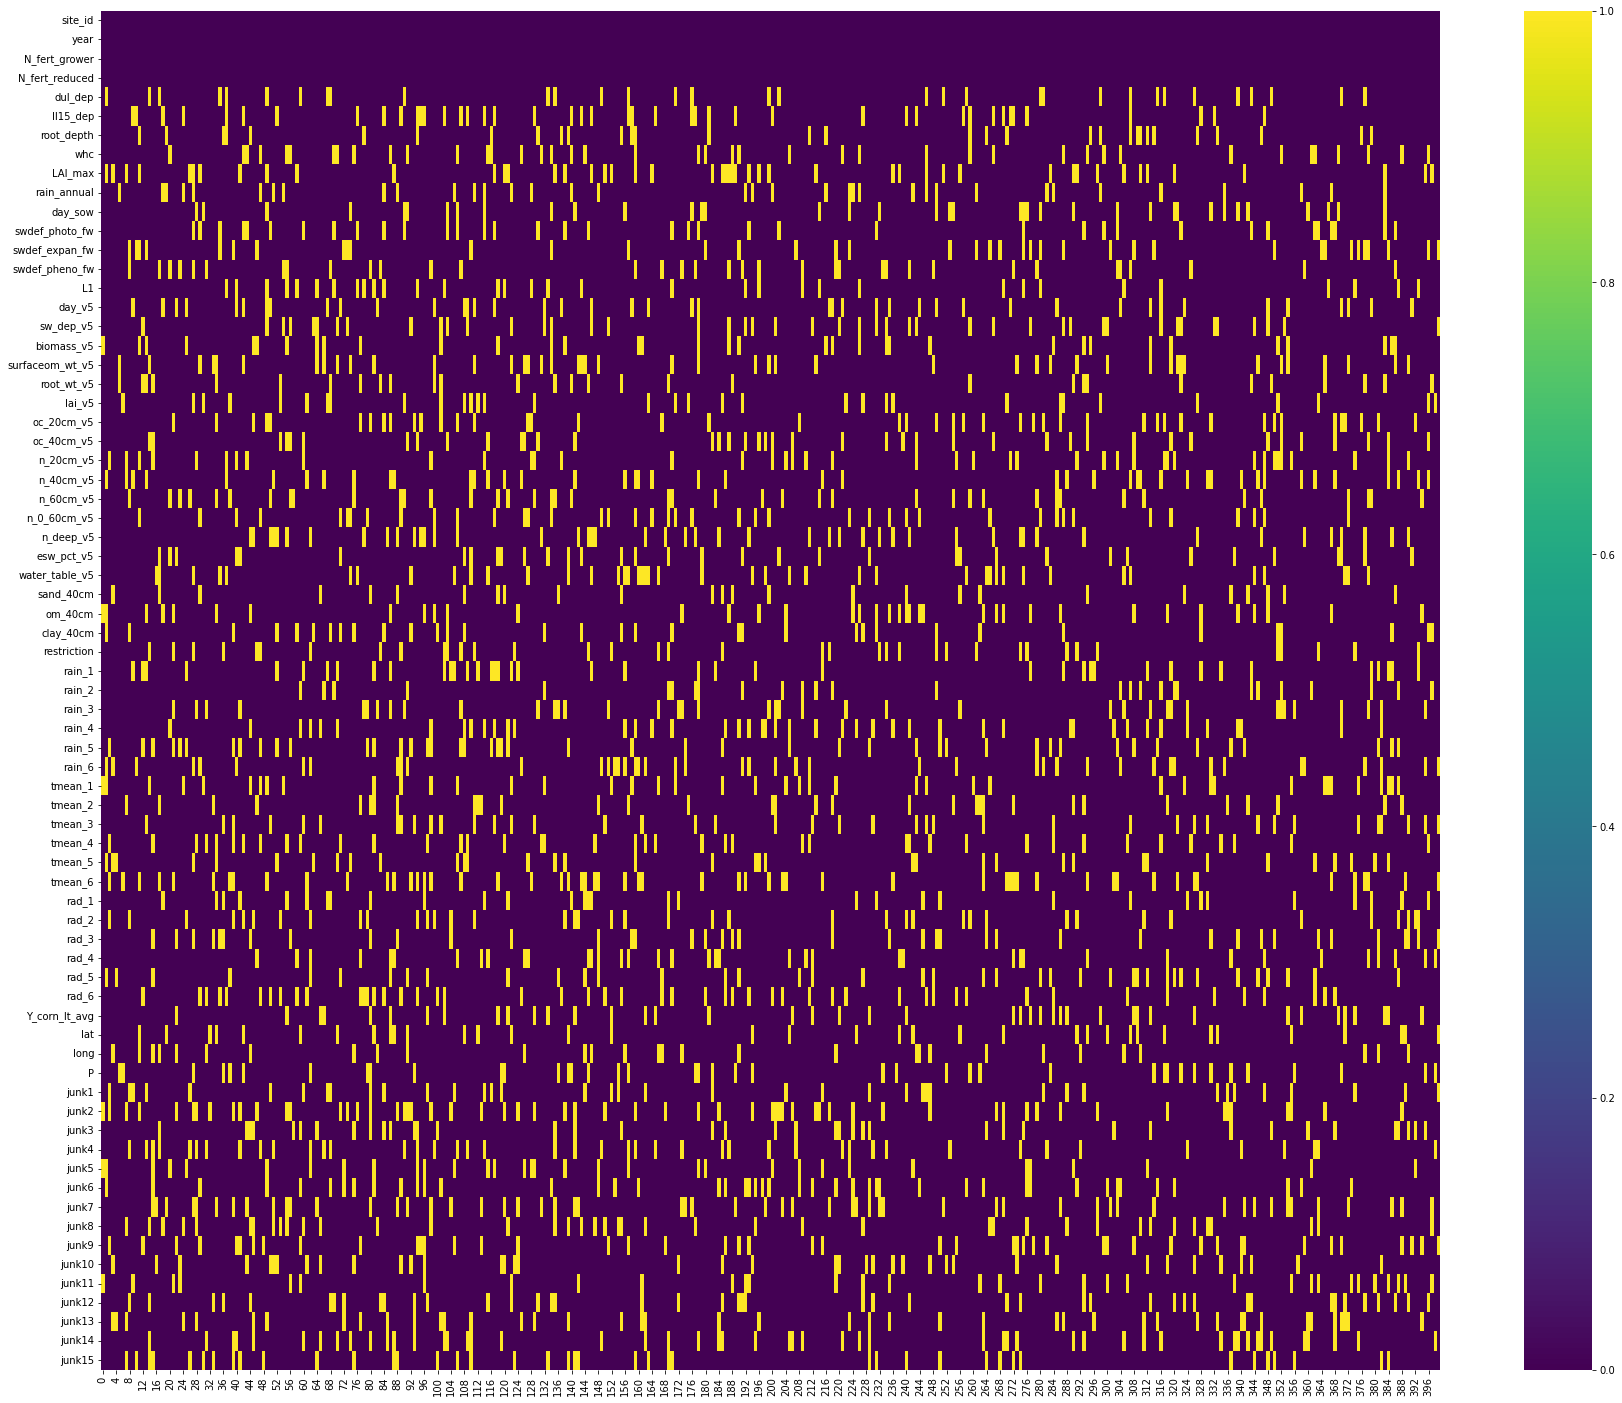

In [10]:
plt.figure(figsize=(30, 25))
sns.heatmap(predictors.isna().transpose(), cmap="viridis")

👉👉 The heatmap shows the missingness relationship of the dataset as seen in `predictors.info().` There are only 4 out of the 71 columns in the `predictor.csv` that have complete observations, while the remaining 67 columns have some level of missing values.

In order to deal with the missing values, we have to first understand the missingness:
- Dropping the rows where there are missing values is not a good idea because as seen from the heatmap above, there are missing values across almost all the rows, and so if we dropped the rows, we would get rid of most of the data **The missingness is not MCAR**.
- The missingness of the `predictor.csv` dataset is **MAR.**
- Hence, the best way of dealing with the missingness will be to consider imputatation. Most obvious idea will be to use the average. But because about 10% of the dataset in each columns are missing, adding the average might not be the most effective idea. Therefore the most efficient approach willbe to use the K nearest neighbors (KNN) for the imputation.

PS: 
MCAR- Missing completely at random; MAR- Missing at random; MNAR- Missing not at random (Intentionally missing values!)

##### Before Imputing, it is always a good practice to understand the features using EDA
I am using the heatmap to see the relevant features and the correlation between each features.

<AxesSubplot:>

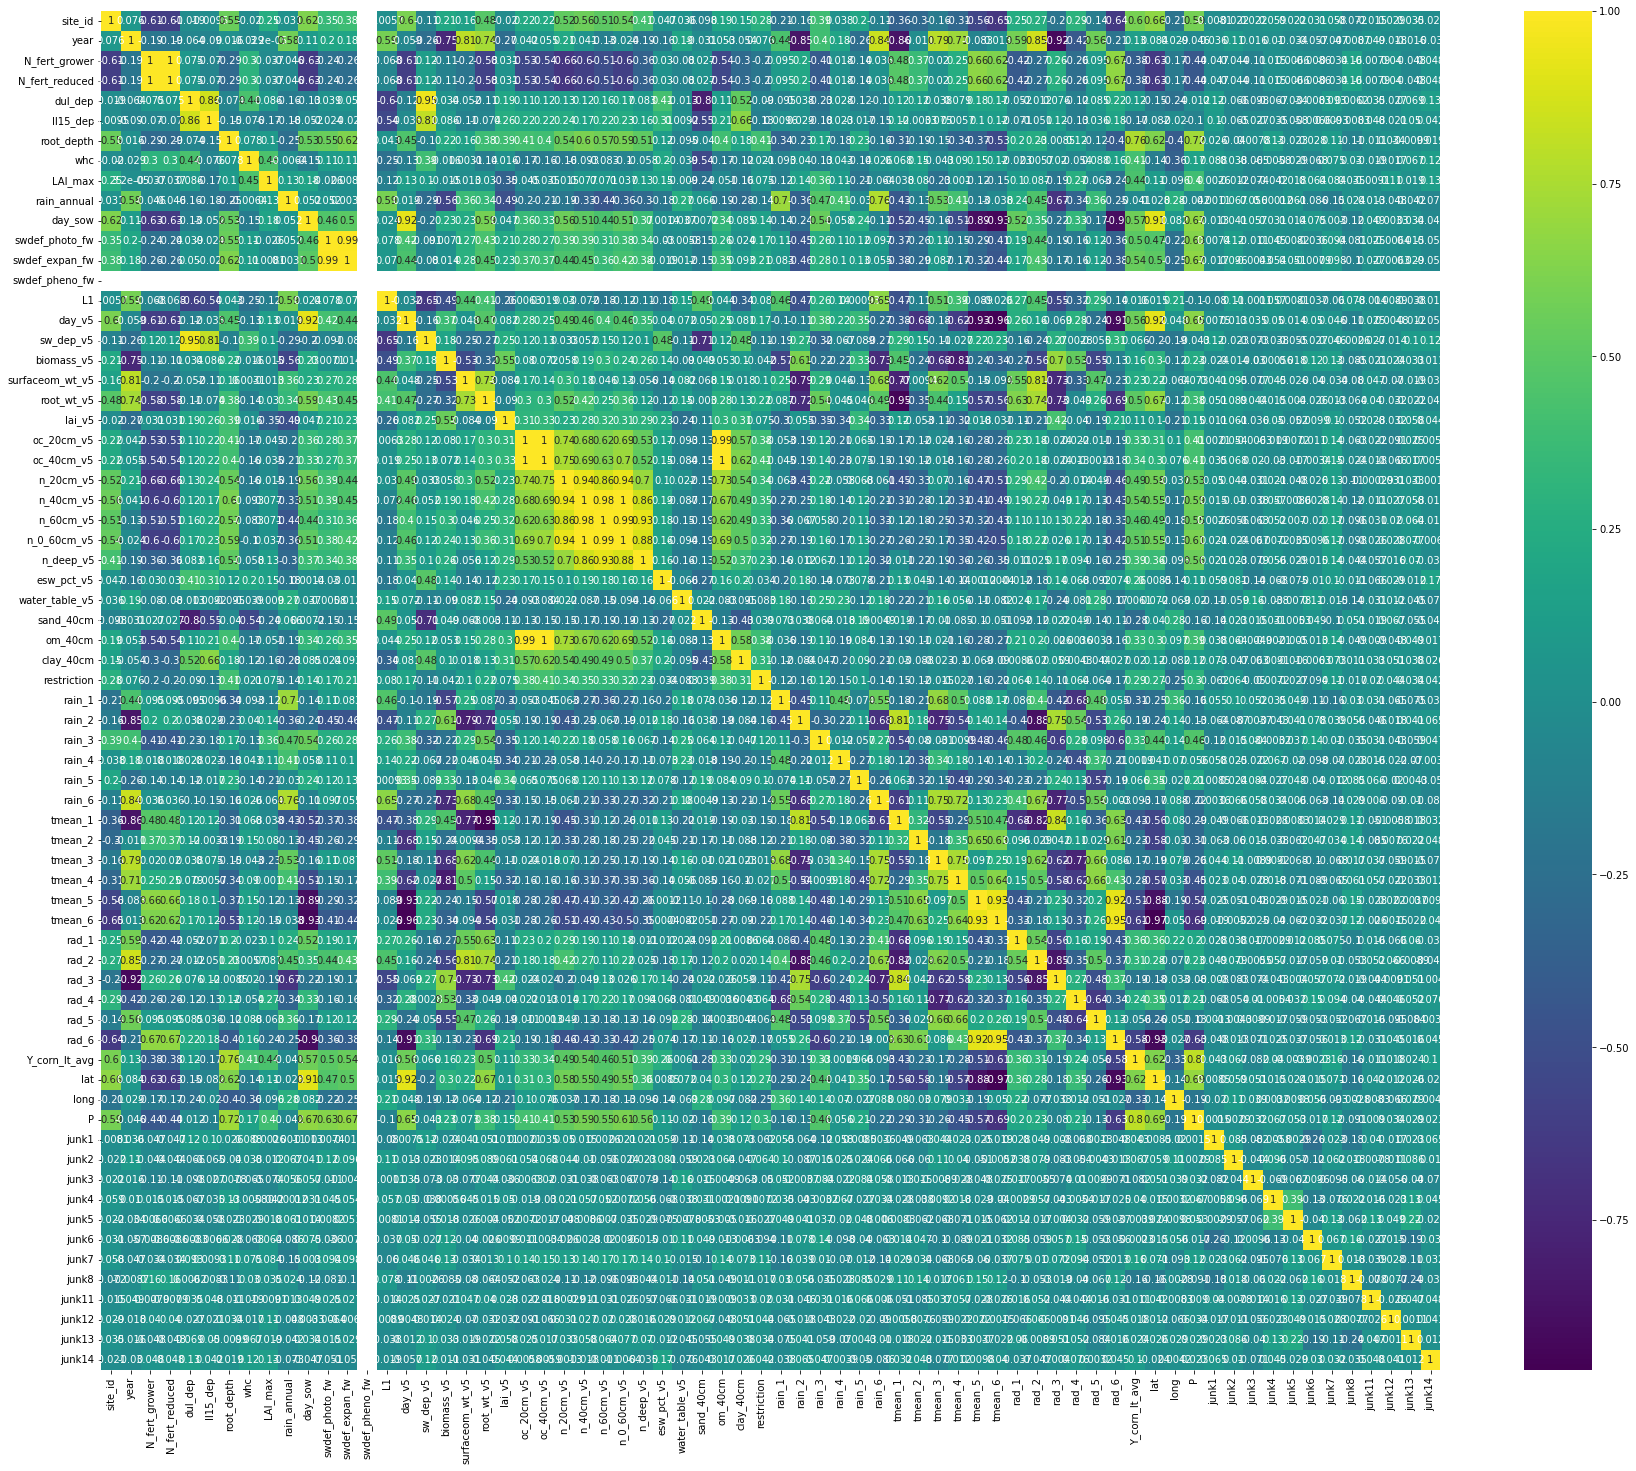

In [11]:
plt.figure(figsize=(30, 25))
sns.heatmap(predictors.corr(), annot=True, cmap="viridis")

👉👉 As seen from the correlated map that the junk features 1-14 are weakly correlated with any of the features. Therefore, the first step of dimensionality reduction will be to drop these features.

Also, I had almost wanted to perform encoding on junk 9, 10, 15, seeing that their datatype were object (It would have not been a good use of time, and that's what the EDA helped me avoid!

👉👉 Also, I was curious to look at the `swdef_pheno_fw` feature as the white color cuts across


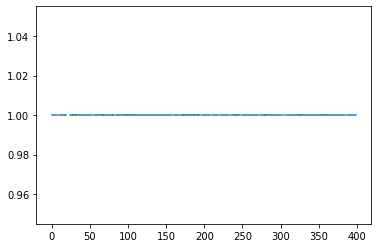

In [12]:
plt.plot(predictors['swdef_pheno_fw'])

👉👉 Seeing that there is no variance in the `swdef_pheno_fw` feature, I will as well drop the feature.

In [13]:
new_pred = predictors.drop(columns=['swdef_pheno_fw', 'junk1', 'junk2',
       'junk3', 'junk4', 'junk5', 'junk6', 'junk7', 'junk8', 'junk9', 'junk10',
       'junk11', 'junk12', 'junk13', 'junk14', 'junk15'])
new_pred.columns

Index(['site_id', 'year', 'N_fert_grower', 'N_fert_reduced', 'dul_dep',
       'll15_dep', 'root_depth', 'whc', 'LAI_max', 'rain_annual', 'day_sow',
       'swdef_photo_fw', 'swdef_expan_fw', 'L1', 'day_v5', 'sw_dep_v5',
       'biomass_v5', 'surfaceom_wt_v5', 'root_wt_v5', 'lai_v5', 'oc_20cm_v5',
       'oc_40cm_v5', 'n_20cm_v5', 'n_40cm_v5', 'n_60cm_v5', 'n_0_60cm_v5',
       'n_deep_v5', 'esw_pct_v5', 'water_table_v5', 'sand_40cm', 'om_40cm',
       'clay_40cm', 'restriction', 'rain_1', 'rain_2', 'rain_3', 'rain_4',
       'rain_5', 'rain_6', 'tmean_1', 'tmean_2', 'tmean_3', 'tmean_4',
       'tmean_5', 'tmean_6', 'rad_1', 'rad_2', 'rad_3', 'rad_4', 'rad_5',
       'rad_6', 'Y_corn_lt_avg', 'lat', 'long', 'P'],
      dtype='object')

<AxesSubplot:>

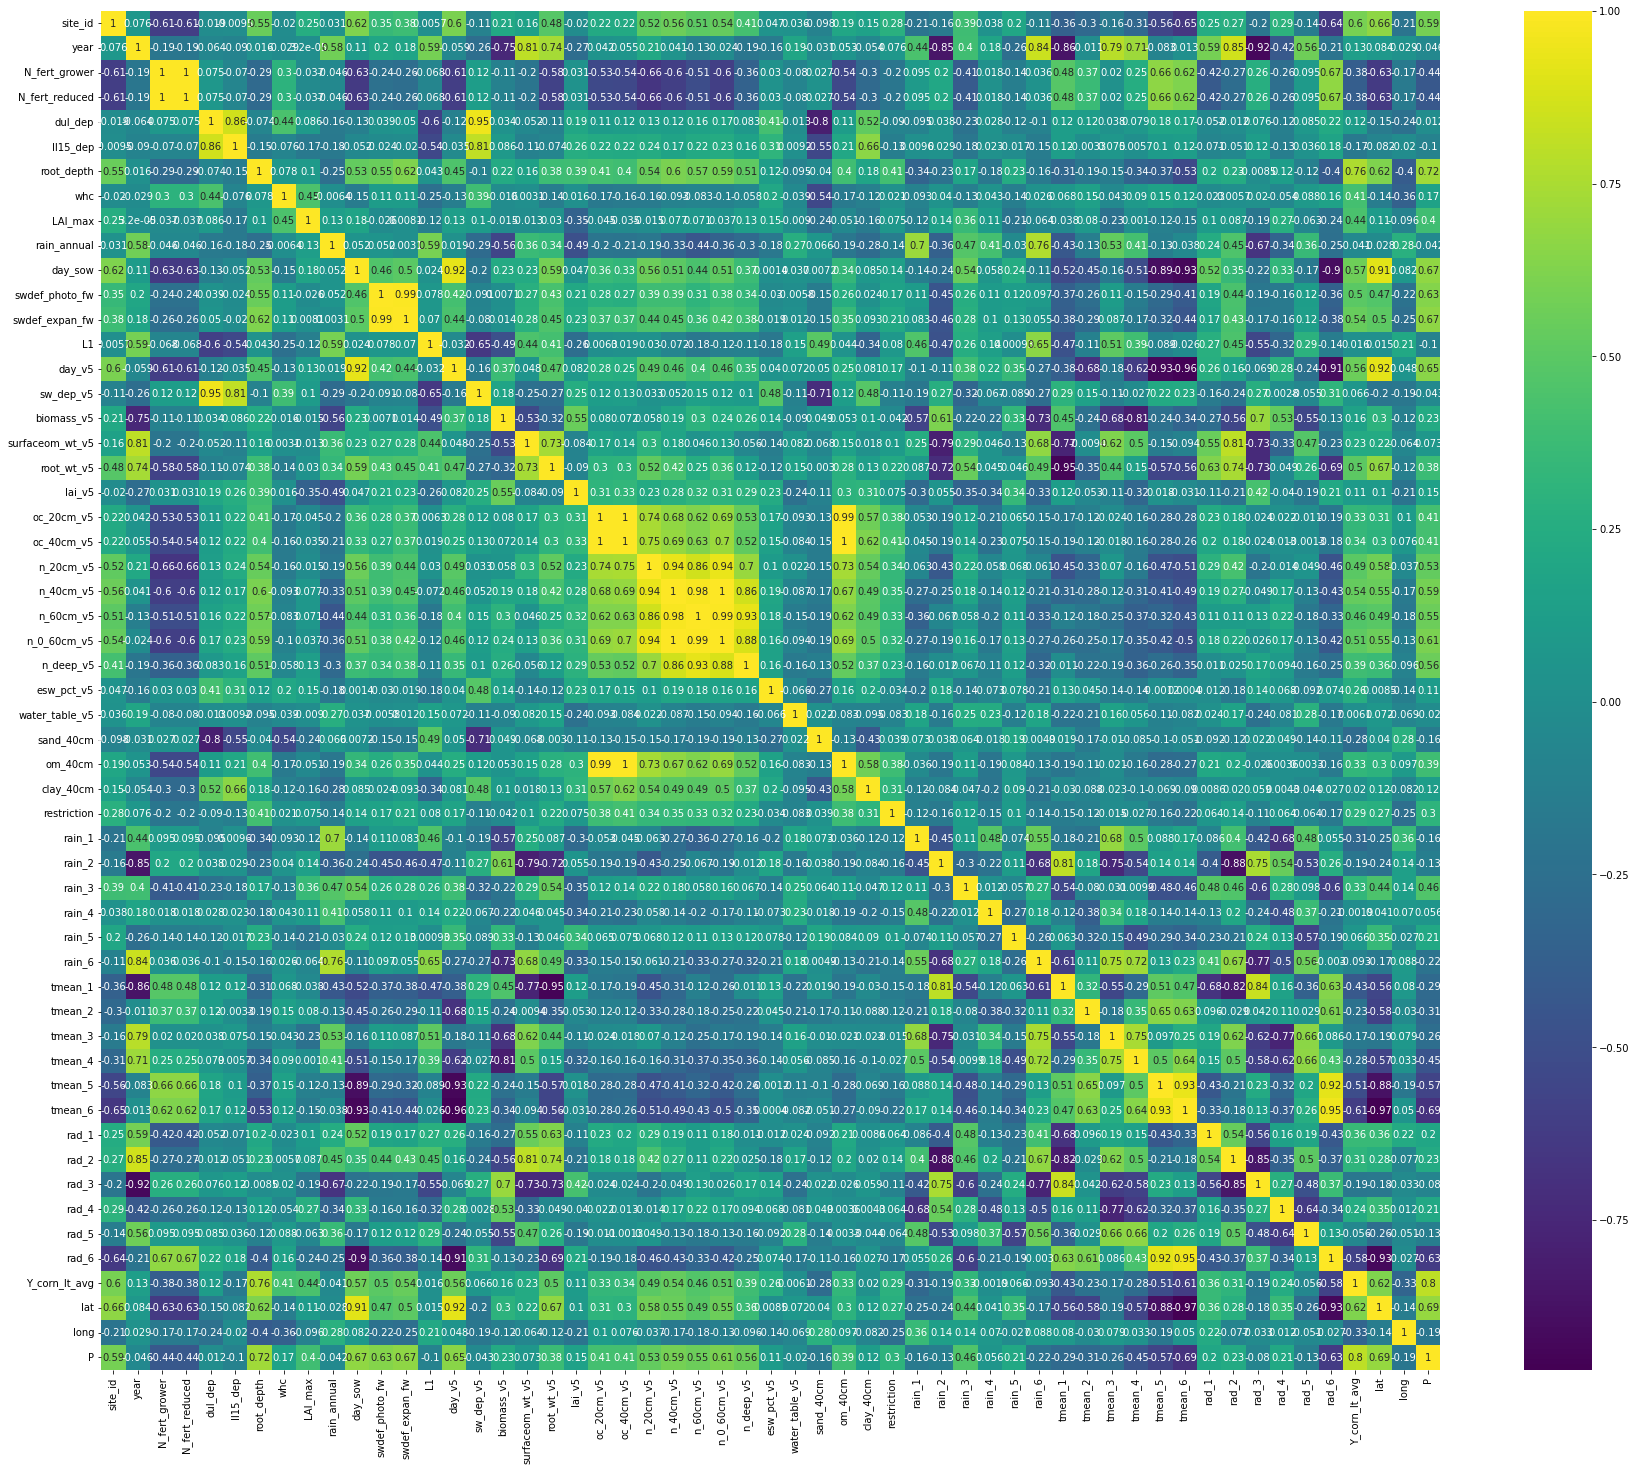

In [14]:
#  Displaying the correlation with the selected features
plt.figure(figsize=(30, 25))
sns.heatmap(new_pred.corr(), annot=True, cmap="viridis")

#### Encoding
The year is categorical, so, it will be a great idea to convert it to 1 and 2. Where 1 represesnts 2017 and 2 represents 2018

In [15]:
year_mapping = {2017: 1, 2018: 2}
new_pred['year'] = new_pred['year'].map(year_mapping)

# The inverse mapping can be done doing the following
# inv_year_mapping = {v: k for k, v in year_mapping.items()}
# new_pred['year'] = new_pred['year'].map(inv_year_mapping)

In [16]:
new_pred.head(10) 

site_id  year  N_fert_grower  N_fert_reduced  dul_dep  ll15_dep  \
0        6     1            200             160    601.0     327.0   
1       24     1            190             150      NaN     335.1   
2       26     2            220             180    619.0     346.8   
3       42     1            200             160    609.5     335.5   
4       60     1            200             160    599.7     326.1   
5       74     2            140             100    240.4     137.5   
6      105     2            220             180    618.0     335.6   
7      114     1            200             160    608.2     324.7   
8      116     1            200             160    619.4     341.6   
9      120     2            210             170    630.0       NaN   

   root_depth    whc  LAI_max  rain_annual  ...  rad_1  rad_2  rad_3  rad_4  \
0      1565.0  274.0    3.164       1064.0  ...  11.67  19.09  22.54  20.27   
1      1573.0  272.7      NaN       1008.0  ...  11.63  19.17  22.73  20.28   
2      1528.0  272.2    3.106       1469.0  ...  11.29    NaN  19.47  17.00   
3      1558.0  274.0      NaN        964.0  ...  11.50  19.36  22.41  20.28   
4      1584.0  273.7    3.174       1145.0  ...  11.64  18.73  22.27  20.49   
5      1581.0  102.9    2.618          NaN  ...  11.15  21.05  19.37  18.16   
6      1592.0  282.4    3.496       1192.0  ...  10.97  20.46  19.46  17.79   
7      1598.0  283.6      NaN       1049.0  ...  11.06  18.87  21.78  20.50   
8      1607.0  277.8    3.506       1049.0  ...  11.06    NaN  21.78  20.50   
9      1583.0  266.3    3.510       1220.0  ...  10.86  20.74  19.31  17.46   

   rad_5  rad_6  Y_corn_lt_avg    lat   long       P  
0  20.78  12.58        11820.0  39.15 -88.27  1383.0  
1    NaN  12.51        11930.0  39.04 -88.43  1400.0  
2  21.95  12.18        11330.0  39.06 -88.34  1470.0  
3  21.26  12.62        11700.0  39.01    NaN  1425.0  
4    NaN  12.35        11530.0  39.08 -88.02  1496.0  
5  21.30  12.01         7069.0  38.98 -87.51     NaN  
6  21.03  12.32        11700.0  38.94 -89.70     NaN  
7  20.60  12.56        11590.0  38.86 -89.98  1391.0  
8  20.60  12.56        11560.0  38.91 -90.02  1397.0  
9  21.10  12.35        11500.0  38.89 -89.95  1542.0  

[10 rows x 55 columns]

#### Imputation of missing value using KNN

In [17]:
# extracting the arrays from the missing features
missn_feat = new_pred.columns[4:]
missn_arr = new_pred[missn_feat].to_numpy()

# Using the KNNImputer from scikit learn
imputer = KNNImputer(n_neighbors=4)
filled_arr = imputer.fit_transform(missn_arr)

# Creating new dataframe with the imputed values
first_four = new_pred[new_pred.columns[:4]]  # first four columns of the new_feat
filled_feat = pd.DataFrame(filled_arr, columns=missn_feat)  # new df for the imputed array
complt_feat = pd.concat([first_four, filled_feat], axis=1, join='inner')

# displaying the imputed DataFrame
complt_feat.head(10)

site_id  year  N_fert_grower  N_fert_reduced  dul_dep  ll15_dep  \
0        6     1            200             160    601.0   327.000   
1       24     1            190             150    606.8   335.100   
2       26     2            220             180    619.0   346.800   
3       42     1            200             160    609.5   335.500   
4       60     1            200             160    599.7   326.100   
5       74     2            140             100    240.4   137.500   
6      105     2            220             180    618.0   335.600   
7      114     1            200             160    608.2   324.700   
8      116     1            200             160    619.4   341.600   
9      120     2            210             170    630.0   342.725   

   root_depth    whc  LAI_max  rain_annual  ...  rad_1    rad_2  rad_3  rad_4  \
0      1565.0  274.0   3.1640      1064.00  ...  11.67  19.0900  22.54  20.27   
1      1573.0  272.7   3.3170      1008.00  ...  11.63  19.1700  22.73  20.28   
2      1528.0  272.2   3.1060      1469.00  ...  11.29  21.1675  19.47  17.00   
3      1558.0  274.0   3.3030       964.00  ...  11.50  19.3600  22.41  20.28   
4      1584.0  273.7   3.1740      1145.00  ...  11.64  18.7300  22.27  20.49   
5      1581.0  102.9   2.6180      1300.25  ...  11.15  21.0500  19.37  18.16   
6      1592.0  282.4   3.4960      1192.00  ...  10.97  20.4600  19.46  17.79   
7      1598.0  283.6   3.3905      1049.00  ...  11.06  18.8700  21.78  20.50   
8      1607.0  277.8   3.5060      1049.00  ...  11.06  19.0825  21.78  20.50   
9      1583.0  266.3   3.5100      1220.00  ...  10.86  20.7400  19.31  17.46   

     rad_5  rad_6  Y_corn_lt_avg    lat     long        P  
0  20.7800  12.58        11820.0  39.15 -88.2700  1383.00  
1  20.6275  12.51        11930.0  39.04 -88.4300  1400.00  
2  21.9500  12.18        11330.0  39.06 -88.3400  1470.00  
3  21.2600  12.62        11700.0  39.01 -88.7175  1425.00  
4  20.6400  12.35        11530.0  39.08 -88.0200  1496.00  
5  21.3000  12.01         7069.0  38.98 -87.5100  1782.25  
6  21.0300  12.32        11700.0  38.94 -89.7000  1557.25  
7  20.6000  12.56        11590.0  38.86 -89.9800  1391.00  
8  20.6000  12.56        11560.0  38.91 -90.0200  1397.00  
9  21.1000  12.35        11500.0  38.89 -89.9500  1542.00  

[10 rows x 55 columns]

👉👉 Before Scaling was done, I used the forward regression Model in R to capture the relevant features that will optimize the ML Model. 

The reason I did this was because some of the features are categorical such as the site_id and year. Hence, I wanted to confirm if I could possibly remove or include the features in the ML algorithm for scaling.

##### Saving files to be used in R

In [18]:
complt_feat.to_csv('complete_pred.csv')
response.to_csv('response.csv')

###### Just for FUN!
Confirming to see if the site_id's row are arranged in the exact position of the predictors and response dataset

In [19]:
check = np.array(predictors['site_id'])  == np.array(response_df['site_id'])
np.unique(check)

array([ True])

### 3:
Note that some of the features are labeled as “junk” to indicate that we know that they 
have no relationship to our targets. However, let’s pretend that you did not know that. 
Implement a programmatic/algorithmic approach that identifies all potential junk 
features for removal. Report how many of these junk features your approach was able 
to identify. Feel free to ignore junk features in the following steps of your analysis.

#### Programmatic /algorithm approach was done using Forward Regression and Lasso analysis using ... library in R

The EDA section helped in eliminating the `junks` and the `swdef_pheno_fw` as they produced a very weak correlation as compared to other features.

I further used Forward regression and LASSO to obtain the relevant features that can be used to predict both responses.
I used all the data for the Forward regression but splitted the data into train (300) and test(100) for the LASSO.

The resulting correlation for the actual and predicted values in the LASSO analysis were established and the highest correlation for the number of features was similar to the forward regression output.

***See the attached markdown and pdf of the R analysis for more details***

####  yield_bu_acre Response Analysis
- There were 16 features that produced the lowest AIC for `yield_bu_acre`.
- The features are :  rain_1, P, swdef_expan_fw, rain_annual, n_60cm_v5, root_wt_v5, Y_corn_lt_avg, root_depth, lai_v5, tmean_3, biomass_v5, esw_pct_v5, rad_3, N_fert_grower, rad_6, and tmean_4

- For LASSO, the highest correlation was found to range from feature 5 - 14, with a max of 6 features resulting in a correlation ~ 0.27

####  plantN_lb_acre Response Analysis
- There were 18 features that produced the lowest AIC for `yield_bu_acre`.
- The features are :   rain_1, L1 + tmean_5, ll15_dep, rain_4, swdef_photo_fw, P, lai_v5, tmean_4, root_depth, whc, n_60cm_v5, sw_dep_v5, rain_annual, rad_6, restriction, biomass_v5, rad_2

- For LASSO, the highest correlation was found to range from feature 5 - 17, with a max of 6 features resulting in a correlation ~ 0.32

**PS** AIC stands for (Akaike’s Information Criteria), a metric developped by the Japanese Statistician, Hirotugu Akaike, 1970. The basic idea of AIC is to penalize the inclusion of additional variables to a model. It adds a penalty that increases the error when including additional terms. **The lower the AIC, the better the model.** [Ref](http://www.sthda.com/english/articles/38-regression-model-validation/158-regression-model-accuracy-metrics-r-square-aic-bic-cp-and-more/#:~:text=AICc%20is%20a%20version%20of,AIC%20developed%20by%20Colin%20Mallows.)

#### From the R analysis, It will be good to preview the correlation of the feature to see how well correlated the features are before going ahead with the Machine Learning Training

In [20]:
res_BA = ['rain_1', 'P', 'swdef_expan_fw', 'rain_annual', 'n_60cm_v5', 'root_wt_v5', 'Y_corn_lt_avg', 'root_depth', 'lai_v5', 
          'tmean_3', 'biomass_v5', 'esw_pct_v5', 'rad_3', 'N_fert_grower', 'rad_6', 'tmean_4']

res_LA = ['rain_1', 'L1','tmean_5', 'll15_dep', 'rain_4', 'swdef_photo_fw', 'P', 'lai_v5', 'tmean_4', 'root_depth', 'whc', 
          'n_60cm_v5', 'sw_dep_v5', 'rain_annual', 'rad_6', 'restriction', 'biomass_v5', 'rad_2']

#### Visualizing  the Correlation Map to be used for Response `yield_bu_acre`

<AxesSubplot:>

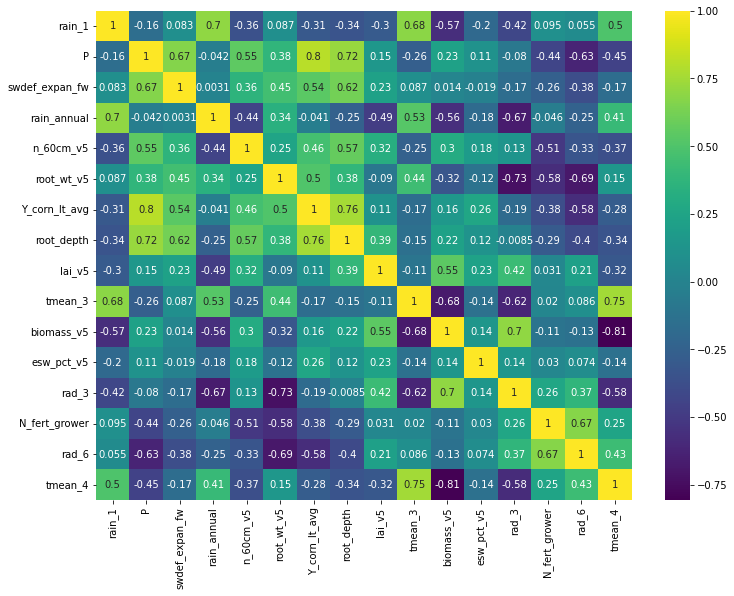

In [21]:
#  Displaying the correlation with the selected features
plt.figure(figsize=(12, 9))
sns.heatmap(new_pred[res_BA].corr(), annot=True, cmap="viridis")

#### Visualizing  the Correlation Map to be used for Response `plantN_lb_acre`

<AxesSubplot:>

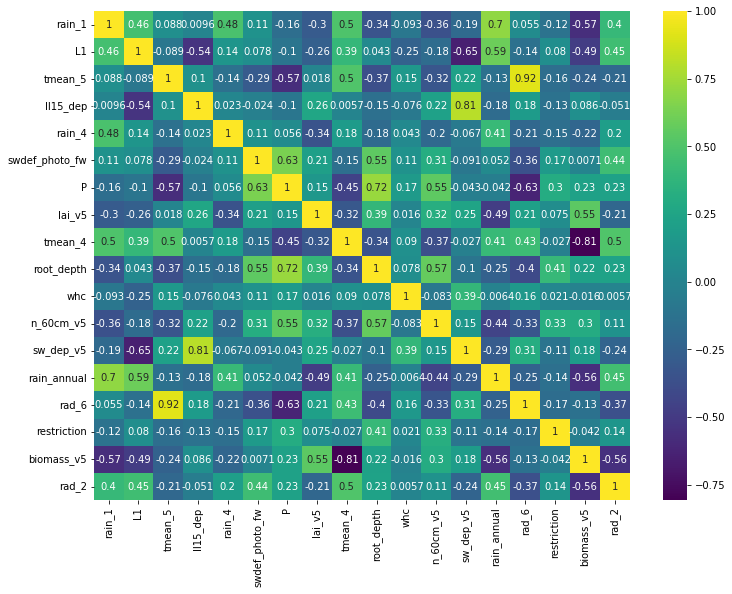

In [22]:
#  Displaying the correlation with the selected features
plt.figure(figsize=(12, 9))
sns.heatmap(new_pred[res_LA].corr(), annot=True, cmap="viridis")

### 4:
Train supervised ML algorithms to **predict whether the response at a given site will be 
positive (i.e., greater than zero).** Do this for both target responses (It is ok to fit 
separate models to each target response). We encourage you to try various model types 
(e.g., Random Forest, Deep Learning, Regularized regressions, boosted trees, 
ensembles, etc.) to assess how much the choice of algorithm affects the predictions. We 
expect you to use reasonable model evaluation procedures based on out-of-bag 
predictions. Produce a summary table to report model performance for all the trained 
models. 

#### Functions that transform the data to suit the classification problem

In [23]:
def transform_response(arr):
    """Convert the response variables (float) to binary (0s and 1s.)
    
    Where 1s represent the response at a given site will be positive (greater than zero)
    and viceversa.
    
    Params
    ------
    arr: An array of n-diamensions.
    
    Returns an array with zeros and ones
    """
    
    arr = (arr > 0) * 1  # creates a boolean from the array and turns it to zeros and ones
    return arr
        

In [24]:
# In order to move on with the project, further scaling have to be done to the response variables
# response_BA represents 'yield_bu_acre' and response_LB represents 'plantN_lb_acre'

response_BA = response_df[['yield_bu_acre']].apply(transform_response)
response_BA.head()

yield_bu_acre
1              1
3              1
5              0
7              1
9              1

In [25]:
response_LA = response_df[['plantN_lb_acre']].apply(transform_response)
response_LA.head()

plantN_lb_acre
1               1
3               1
5               0
7               1
9               1

#### Creating Class that will accomodate the workflow
Since I am running the ML model on the two responses, creating a class with the respective functionality will be the most efficient way and will enhance repeatability and reduce code duplication.

In [26]:
class MlModel:
    """
    MlModel is a classification machine learning solver.
    
    The use of multiple classification algorithms is used to efficiently predict predict whether 
    the response at a given site will be positive
    
    """
    def __init__(self, feature, label, test_fraction = 0.2):
        """
         Constructor method for the MlModel class.

        Parameters:
        feature: pandas dataframe
            N x k dimension matrix containing the input features, where N is the number of 
            observations and k is the number of features
        label: pandas dataframe
            N x 1 dimension matrix containing the corresponding labels for each input observation
        test_fraction: float
            The fraction of the data to be used as test data. The default value is 0.2 (i.e., 20% 
            of the data is used for testing).
        """
        self.data = feature.to_numpy()  # converts the dataframe to numpy array
        self.label = label.to_numpy().reshape(-1, )
        self.test_fraction = test_fraction
        
    def scaler(self):
        """
        This method performs feature scaling on the input data.

        Returns:
        Tuple:
            X_train_scaled: numpy array
                Scaled training input feature data
            X_test_scaled: numpy array
                Scaled testing input feature data
            y_train: numpy array
                Training labels
            y_test: numpy array
                Testing labels
        """
        start_state = 42  # random seed for solution replication
        X_train, X_test, y_train, y_test = train_test_split(self.data, self.label, 
                                                            test_size=self.test_fraction, random_state=start_state)
        my_scaler = StandardScaler()  # scikit learn library for scaling
        my_scaler.fit(X_train)
        
        X_trained_scaled, X_test_scaled = my_scaler.transform(X_train), my_scaler.transform(X_test)
        return X_trained_scaled, X_test_scaled, y_train, y_test
    
    def ml_classifiers(self, classifier= 'DT'):
        """
        This method trains a classification model on the input data.

        Parameters:
        classifier: str, default 'DT'
            A string specifying the type of classifier to use. There are eleven classifiers that are used.
            Some are variants of each other as seen in the linear and gamma Support Vector Machine Classifier
            (SVM) and the Decision Trees (DT).

        Returns:
        Trained classification model object.
        """
        
        classifier_dict = {'DT': DecisionTreeClassifier(criterion='gini', random_state=0),
                           'KNN': KNeighborsClassifier(3),
                           'SVC_L': SVC(kernel="linear", C=0.025),
                           'SVC_G': SVC(gamma=2, C=1),
                           'GPC': GaussianProcessClassifier(1.0 * RBF(1.0)),
                           'DT2': DecisionTreeClassifier(max_depth=5),
                           'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                           'NN': MLPClassifier(alpha=1, max_iter=1000),
                           'ABC': AdaBoostClassifier(),
                           'GNB': GaussianNB(),
                           'QDA': QuadraticDiscriminantAnalysis()}
            
        selected_classifier = classifier_dict[classifier]
        Xtrain_scale, _, ytrain_scale, _ = self.scaler()

        my_model = selected_classifier.fit(Xtrain_scale, ytrain_scale)  
        
        return my_model
        
        
    def model_score(self, model, X_test, y_test):
        """
        This method calculates the accuracy score of the trained model on the test data.

        Parameters:
        model: sklearn model object
            The trained model object
        X_test: numpy array
            The testing feature data
        y_test: numpy array
            The testing labels

        Returns:
        float:
            The accuracy score of the model on the testing data.
        """
        
        return model.score(X_test, y_test)
        



### Predicting the response of  `yield_bu_acre`

In [27]:
resBA_model = MlModel(complt_feat[res_BA], response_BA)

# extracting the scaled value to be used to test the score of the algorithm
_, X_test_scaled, _, y_test = resBA_model.scaler()
model = resBA_model.ml_classifiers()
score = resBA_model.model_score(model, X_test_scaled, y_test)

In [28]:
y_pred= model.predict(X_test_scaled)
y_pred

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [29]:
print('The Model Score using Decision Tree is:', score)

The Model Score using Decision Tree is: 0.9375


#### More analysis on the accuracy in getting the number of `false positives` and `false negatives`

In [30]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[ 7,  2],
       [ 3, 68]], dtype=int64)

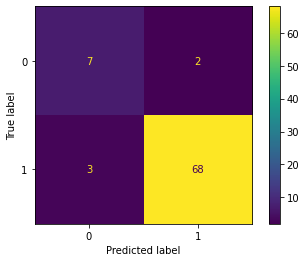

In [31]:
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)

From the above confusion matrix, we see that the algorithms performs very well in predicting both conditions 1s `(the response at a given site will be positive)` and vice versa. 
The algorithm failed to classify three (3) positive response, labeling them as `false negatives` and also failed to classify two of the nine negative responses, labeling them as `false positive`

👉👉 For the Project, since the algorithms performs well with minimal error in classifying the negatives, we are sure that our machine learning model is scalable and will be more pragmatic in giving an accurate result that a certain site will be positive.

#### Trying more algorithms to get the Score

In [32]:
# Creating a dictionary to store up the score for the rest of the Algorithms
algorithm_score ={}
algorithms = ['DT', 'KNN', 'SVC_L', 'SVC_G', 'GPC', 'DT2', 'RF', 'NN', 'ABC', 'GNB', 'QDA']

In [33]:
resBA_model = MlModel(complt_feat[res_BA], response_BA)

for alg in algorithms:
    
    # extracting the scaled value to be used to test the score of the algorithm
    _, X_test_scaled, _, y_test = resBA_model.scaler()
    model = resBA_model.ml_classifiers(classifier= alg)
    score = resBA_model.model_score(model, X_test_scaled, y_test)
    
    # Adding the score to the  algortihm_score dictionary
    algorithm_score[alg] = score

In [34]:
model_eval_BA = pd.DataFrame.from_dict(algorithm_score, orient='index', columns=['yield_bu_acre'])
model_eval_BA.reset_index(inplace=True)
model_eval_BA

index  yield_bu_acre
0      DT         0.9375
1     KNN         0.9375
2   SVC_L         0.8875
3   SVC_G         0.9000
4     GPC         0.9500
5     DT2         0.9500
6      RF         0.9375
7      NN         0.9250
8     ABC         0.9375
9     GNB         0.8625
10    QDA         0.9375

### Predicting the response of  `plantN_lb_acre`

In [35]:
resLA_model = MlModel(complt_feat[res_LA], response_LA)

# extracting the scaled value to be used to test the score of the algorithm
_, X_test_scaled, _, y_test = resLA_model.scaler()
model = resLA_model.ml_classifiers()
score = resLA_model.model_score(model, X_test_scaled, y_test)

In [36]:
y_test

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [37]:
y_pred= model.predict(X_test_scaled)
y_pred

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [38]:
print('The Model Score using Decision Tree is:', score)

The Model Score using Decision Tree is: 0.9375


#### More analysis on the accuracy in getting the number of `false positives` and `false negatives`

In [39]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[ 4,  2],
       [ 3, 71]], dtype=int64)

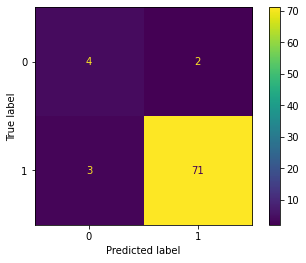

In [40]:
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)

From the above confusion matrix, we see that the algorithms also performs very well in predicting both conditions 1s `(the response at a given site will be positive)` and vice versa. 
The algorithm failed to classify three (3) positive response, labeling them as `false negatives` and also failed to classify two of the nine negative responses, labeling them as `false positive`

Since, there was only six negatives, and two were wrongly classified as positive, the algorithms try to find the positive values and could be biased towards stating that the response of a given site will positive.

In [41]:
# Creating a dictionary to store up the score for the rest of the Algorithms
algorithm_score_resLA ={}
algorithms = ['DT', 'KNN', 'SVC_L', 'SVC_G', 'GPC', 'DT2', 'RF', 'NN', 'ABC', 'GNB', 'QDA']

In [42]:
# extracting the scaled value to be used to test the score of the algorithm
resLA_model = MlModel(complt_feat[res_LA], response_LA)

for alg in algorithms:
    
    # extracting the scaled value to be used to test the score of the algorithm
    _, X_test_scaled, _, y_test = resLA_model.scaler()
    model = resLA_model.ml_classifiers(classifier= alg)
    score = resLA_model.model_score(model, X_test_scaled, y_test)
    
    # Adding the score to the  algortihm_score dictionary
    algorithm_score_resLA[alg] = score

In [43]:
model_eval_LA = pd.DataFrame.from_dict(algorithm_score_resLA, orient='index', 
                                       columns=['plantN_lb_acre'])
model_eval_LA.reset_index(inplace=True)
model_eval_LA

index  plantN_lb_acre
0      DT          0.9375
1     KNN          0.9500
2   SVC_L          0.9250
3   SVC_G          0.9375
4     GPC          0.9500
5     DT2          0.9375
6      RF          0.9250
7      NN          0.9625
8     ABC          0.9375
9     GNB          0.8750
10    QDA          0.9375

#### Summary Table

In [44]:
classification_alg = ['Decision Tree Classifier', 'KNeighbors Classifier', 'SVC(kernel="linear")',
                      'SVC(gamma=2)', 'Gaussian Process Classifier (with RBF)', 
                      'Decision Tree Classifier (max depth=5)', 'Random Forest Classifier', 
                      'MLPClassifier (Neural Network)', 'AdaBoostClassifier', 'Gaussian Naive Bayes',
                      'Quadratic Discriminant Analysis']

model_summary =pd. DataFrame(classification_alg, columns=['Classification Algorithm'])

In [45]:
model_summary['yield_bu_acre'] = model_eval_BA['yield_bu_acre']
model_summary['plantN_lb_acre'] = model_eval_LA['plantN_lb_acre']
model_summary

Classification Algorithm  yield_bu_acre  plantN_lb_acre
0                 Decision Tree Classifier         0.9375          0.9375
1                    KNeighbors Classifier         0.9375          0.9500
2                     SVC(kernel="linear")         0.8875          0.9250
3                             SVC(gamma=2)         0.9000          0.9375
4   Gaussian Process Classifier (with RBF)         0.9500          0.9500
5   Decision Tree Classifier (max depth=5)         0.9500          0.9375
6                 Random Forest Classifier         0.9375          0.9250
7           MLPClassifier (Neural Network)         0.9250          0.9625
8                       AdaBoostClassifier         0.9375          0.9375
9                     Gaussian Naive Bayes         0.8625          0.8750
10         Quadratic Discriminant Analysis         0.9375          0.9375

👉👉 The highest score is 95% accuracy for both `yield_bu_acre` and `plantN_lb_acre` response.

Guassian Process Classifier with RBF had the most accurate score for the `yield_bu_acre` and KNeighbors Classifier, Gaussian Process Classifier with RBF, and MLPClassifier (Neural Network) had the highest for the `plantN_lb_acre` response

### 5:
Pick the best-performing model(s) for each target and use it to address the following 
questions:
- Are there key site characteristics (or grouping of site characteristics) that are most strongly associated with whether a site would be responsive to 40 lb/ac of N fertilizer?
- Is there any discernible pattern in the learned relationships between the target and the most important features? 
- If we were to repeat this experiment in the future, what would be the minimum number of sites needed to train a reasonably accurate model?


#### In order to validate the key site characteristics, I will be using the HiPlot Visualization to help understand the strong features

👉👉 **plantN_lb_acre** Response

In [46]:
LA_data = complt_feat[res_LA]
LA_data['plantN_lb_acre'] = response_LA.reset_index()['plantN_lb_acre']
hip.Experiment.from_dataframe(LA_data).display()

<IPython.core.display.Javascript object>

👉👉 **yield_bu_acre** Response

In [47]:
BA_data = complt_feat[res_BA]
BA_data['yield_bu_acre'] = response_BA.reset_index()['yield_bu_acre']
hip.Experiment.from_dataframe(BA_data).display()

<IPython.core.display.Javascript object>

#### Answers:
- The HiPlot which stands for High dimensional Interactive Plotting shows the trend across each feature used.

- In the Presentation, I have takin snap shots of the Hiplots that answers Question a and b.
- Question c is answered below


👉👉 In order to know the minimum number of sites needed to train a reasonably accurate model, I will further reduce the training data and see how much the accuracy drops.


---
**yield_bu_acre** Response

👉👉 **50% of Training Data**

In [48]:
resBA_model = MlModel(complt_feat[res_BA], response_BA, test_fraction=0.5)

# extracting the scaled value to be used to test the score of the algorithm
_, X_test_scaled, _, y_test = resBA_model.scaler()
model = resBA_model.ml_classifiers(classifier='GPC')
score = resBA_model.model_score(model, X_test_scaled, y_test)
score

0.89

👉👉 I would say, about 200  number of sites giving the accuracy

---
**plantN_lb_acre** Response

👉👉 **50% of Training Data**

In [49]:
resLA_model = MlModel(complt_feat[res_LA], response_LA, test_fraction=0.5)

# extracting the scaled value to be used to test the score of the algorithm
_, X_test_scaled, _, y_test = resLA_model.scaler()
model = resLA_model.ml_classifiers(classifier='GPC')
score = resLA_model.model_score(model, X_test_scaled, y_test)
score

0.93

👉👉 Using half of the total data still gives a very good accuracy. The Caveat here is because the number of positive responses are larger than that of the negative response, and so, there will be some bias to the positive response.

With this in mind, I would not want to go below half of the current size. Although, if we keep reducing the training data in the crossvalidation the accuracy doesn't reduce that much, especially using the Gaussian Process Classifier (with RBF).

---

### Naming Convention:
Throughout this notebook I have maintained the variable name ending or having capitalized `BA` represents `plantN_lb_acre` Response, while variable names ending or having capitalized `LA` represents `plantN_lb_acre`.

- `BA:` Bu per Acre
- `LA:` Lb per Acre